In [ ]:
#!pip install frc3223-azurite
#!pip install pynetworktables==2017.0.8
#!pip install pyfrc==2017.1.5

In [2]:
import numpy
from matplotlib import pyplot as plt
from elevator import ElevatorSimulation
from frc3223_azurite import motors
from frc3223_azurite.conversions import *
from frc3223_azurite.pidcontroller import NoThreadingPIDController as PIDController
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib

def plot_position(sim, ylim=None):
    plt.plot(sim.ts, sim.xs)
    if ylim is None:
        ylim = (-sim.max_height_m * 0.1, sim.max_height_m * 1.1)
    plt.ylim(*ylim)
    plt.xlabel('time (s)')
    plt.ylabel('position (m)')
    plt.show()
    
def plot_velocity(sim):
    m2ft = numpy.vectorize(meter_to_feet)
    plt.plot(sim.ts, m2ft(sim.vs))
    plt.ylim(-sim.max_height_m * 0.1, sim.max_height_m * 1.1)
    plt.xlabel('time (s)')
    plt.ylabel('velocity (ft/s)')
    plt.show()

def plot_current(sim, invert=False):
    plt.plot(sim.ts, (-1 if invert else 1) * sim.currents)
    plt.ylim(-sim.motor_system.motor.stall_current * 0.1, sim.motor_system.motor.stall_current * 0.8)
    plt.xlabel('time (s)')
    plt.ylabel('current (A)')
    plt.show()
    

width = inch_to_meter(4)
stage_x = numpy.array([0, 0, width, width, 0])
_stage_y = numpy.array([0, 1, 1, 0, 0])


def animate_lift(sim, frame_interval_ms=50, speed_factor=1):
    assert matplotlib.rcParams['animation.writer'] in matplotlib.animation.writers.list(), 'choose an available writer!'
    fig, ax = plt.subplots()
    stage_y = _stage_y * sim.max_height_m
    base_stage, stage_1, stage_2, carriage = plots = [ax.plot(stage_x, stage_y)[0] for i in range(4)]
    plt.ylim(0, (len(plots) * 2 + 0.1) * sim.max_height_m)
    dt = sim.ts[1]-sim.ts[0]
    n = int(frame_interval_ms / 1000. / dt) # number of data points to skip
    L = len(sim.ts) // n # number of data points sampled at 20 ms
    print (n, L, len(sim.ts))
    def init():
        return (line,)
    def animate(j): 
        i = j * n
        plots[1].set_ydata(stage_y + sim.xs[i])
        plots[2].set_ydata(stage_y + 2 * sim.xs[i])
        plots[3].set_ydata(stage_y * 0.3 + 3 * sim.xs[i])

        return plots


    anim = animation.FuncAnimation(fig, animate, frames=L, interval=frame_interval_ms / speed_factor, blit=True)
    return anim


def animate_climb(sim, frame_interval_ms=50, speed_factor=1):
    assert matplotlib.rcParams['animation.writer'] in matplotlib.animation.writers.list(), 'choose an available writer!'
    fig, ax = plt.subplots()
    stage_y = _stage_y * sim.max_height_m
    base_stage, stage_1, stage_2, carriage = plots = [
        ax.plot(stage_x, stage_y + i * sim.max_height_m)[0] for i in range(4)]
    plt.ylim(0, (len(plots) * 2 + 0.1) * sim.max_height_m)
    dt = sim.ts[1]-sim.ts[0]
    n = int(frame_interval_ms / 1000. / dt) # number of data points to skip
    L = len(sim.ts) // n # number of data points sampled at 20 ms
    print (n, L, len(sim.ts))
    def init():
        return (line,)
    def animate(j): 
        i = j * n
        plots[0].set_ydata(stage_y + sim.xs[i])
        plots[2].set_ydata(stage_y + 2 * sim.max_height_m - sim.xs[i])
        plots[3].set_ydata(stage_y * 0.3 + 3 * sim.max_height_m - 2 * sim.xs[i])

        return plots


    anim = animation.FuncAnimation(fig, animate, frames=L, interval=frame_interval_ms / speed_factor, blit=True)
    return anim


In [5]:
def init(state):
    def pid_source():
        return state.x
    
    def pid_output(v):
        state.motor.set(v)
    state.pid = PIDController(Kp = 0, Ki = 0.0, Kd = 0, Kf = 0.0, source = pid_source, output = pid_output)
    state.pid.setOutputRange(-1, 1)
    state.pid.setSetpoint(.5)
    #state.pid.enable()

def periodic(state):
    state.motor.set(1)
    pass


sim = ElevatorSimulation(
    starting_position_m=0,
    max_height_m=inch_to_meter(44),
    sprocket_radius_m=inch_to_meter(2),
    robot_mass_kg=lbs_to_kg(154),
    stage1_mass_kg=lbs_to_kg(5.0),
    stage2_mass_kg=lbs_to_kg(5.0),
    stage3_mass_kg=lbs_to_kg(20.0),
    stage1_counterweighting_n=lbs_to_N(.0),
    stage2_counterweighting_n=lbs_to_N(0.0),
    init=init,
    periodic=periodic,
    pid_sample_rate_s=0.001,
    gearbox_efficiency=0.65,
    motor_system=motors.MotorSystem(motor=motors.cim, motor_count=2, gearing_ratio=35),
    dt_s=0.0001,
)

print ('stages: ', sim.stages_gravity())
print ('counterweight: ', sim.counterweighting())

stages:  333.73620000000005
counterweight:  0.0


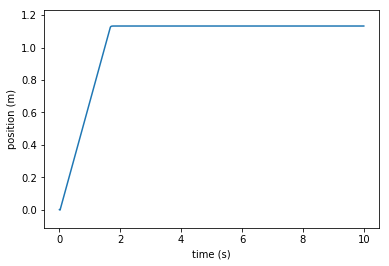

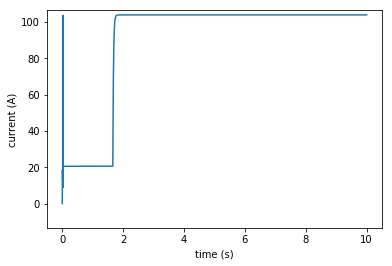

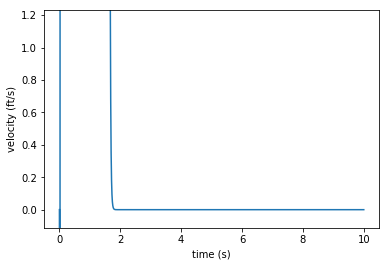

In [6]:
sim.run_lift_sim(timeout=10)
plot_position(sim)
plot_current(sim)
plot_velocity(sim)

In [52]:
HTML(animate_lift(sim).to_html5_video())

250 241 60497


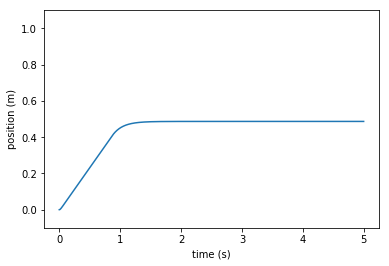

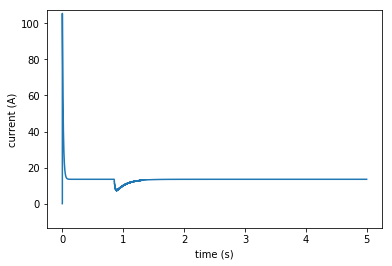

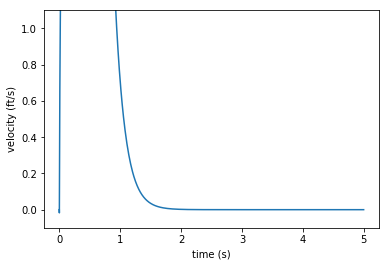

In [54]:
sim.run_climb_sim(timeout=5)
plot_position(sim)
plot_current(sim)
plot_velocity(sim)

In [55]:
HTML(animate_climb(sim).to_html5_video())

250 141 35496
